In [7]:
import pandas as pd
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer

pdf_json = {
    "filename": "keywords_test_1.pdf",
    "pages": [
        {
            "Event Type Code": "Event Type Code: EVT123",
            "Capacity": "Capacity: 5000",
            "Parking Capacity": "Capacity: 5000",
            "Transport Max Capacity": "Capacity: 5000",
            "Number of Gates": "Number of Gates: 4",
            "Number of Restrooms": "Number of Gates: 4",
            "Number of Food Courts": "Number of Gates: 4",
            "Number of First Aid Stations": "Number of Gates: 4",
            "Number of Emergency Exits": "Number of Gates: 4",
            "VIP Zones Flag": "VIP Zones Flag: Yes",
            "Weather Severity": "Weather Severity: Mild"
        }
    ]
}

def prepare_model_input(pdf_json):
    rows = []
    for page in pdf_json["pages"]:
        row = {}
        # Map only columns needed for model
        row["Event_Type"] = page.get("Event Type Code", "Unknown").split(":")[-1].strip()
        row["Stadium"] = "Stadium A"  # Default for mock/demo
        row["Expected_Attendance"] = int(page.get("Capacity", "0").split(":")[-1].strip())
        row["Day_Hour"] = 18  # Default/mock
        weather = page.get("Weather Severity", "Mild").split(":")[-1].strip().lower()
        row["Weather_Score"] = {"mild":0.5, "moderate":0.7, "severe":1.0}.get(weather, 0.5)
        rows.append(row)
    df = pd.DataFrame(rows)
    
    # Example mapping categorical columns to numeric codes (for model)
    df["Event_Type"] = df["Event_Type"].astype("category").cat.codes
    df["Stadium"] = df["Stadium"].astype("category").cat.codes
    return df

df_user = prepare_model_input(pdf_json)
print("Model-ready DataFrame:")
print(df_user)

# Initialize SageMaker Predictor
endpoint_name = "crowd-risk-option1-v2"  # Your deployed endpoint
predictor = Predictor(endpoint_name=endpoint_name)
predictor.serializer = CSVSerializer()

# Predict Base Risk
predictions = predictor.predict(df_user.values)
if isinstance(predictions, bytes):
    predictions = predictions.decode("utf-8")

# Convert to float list
base_risks = [float(r) for r in predictions.strip().split("\n")]
df_user["Base_Risk"] = base_risks
print("Raw model output:", df_user["Base_Risk"].tolist())

# Scenario Adjustment & Recommendation
def adjust_risk_for_scenario(risk, scenario):
    adjustments = {
        "general": 0.0,
        "entry_rush": 0.05,
        "mid_event": 0.1,
        "evacuation": 0.15
    }
    return min(risk + adjustments.get(scenario, 0), 1.0)

def scenario_recommendation(risk, scenario):
    if scenario == "general":
        return "Moderate, consider early arrival" if risk >= 0.5 else "Safe to attend"
    elif scenario == "entry_rush":
        return "Open extra gates" if risk >= 0.5 else "Safe to attend"
    elif scenario == "mid_event":
        return "Redirect crowd to food/restroom areas" if risk >= 0.5 else "Safe to attend"
    elif scenario == "evacuation":
        return "Activate emergency exits and guides" if risk >= 0.5 else "Safe to attend"
    else:
        return "Safe to attend"
        
chosen_scenario = "entry_rush" 

df_user["Scenario_Risk"] = df_user["Base_Risk"].apply(lambda r: adjust_risk_for_scenario(r, chosen_scenario))
df_user["Recommendation"] = df_user["Scenario_Risk"].apply(lambda r: scenario_recommendation(r, chosen_scenario))

# Show Scenario-Based Results
print(f"--- Scenario: {chosen_scenario} ---")
for i, row in df_user.iterrows():
    print(f"Row {i+1}: Congestion_Risk={row['Scenario_Risk']:.3f}, Scenario={chosen_scenario}, Recommendation: {row['Recommendation']}")


Model-ready DataFrame:
   Event_Type  Stadium  Expected_Attendance  Day_Hour  Weather_Score
0           0        0                 5000        18            0.5
Raw model output: [0.015855269506573677]
--- Scenario: entry_rush ---
Row 1: Congestion_Risk=0.066, Scenario=entry_rush, Recommendation: Safe to attend


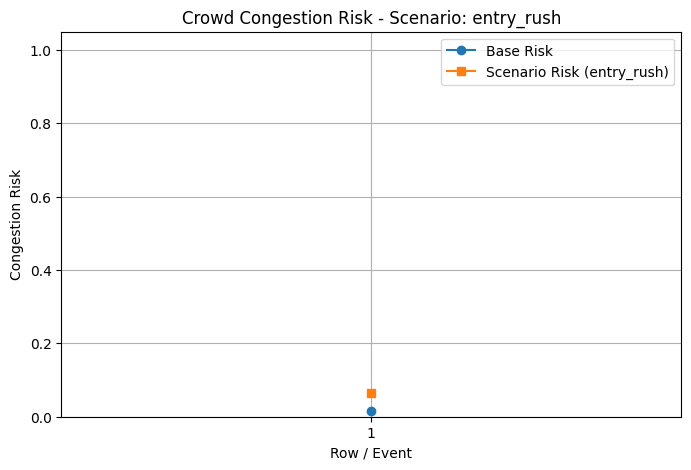

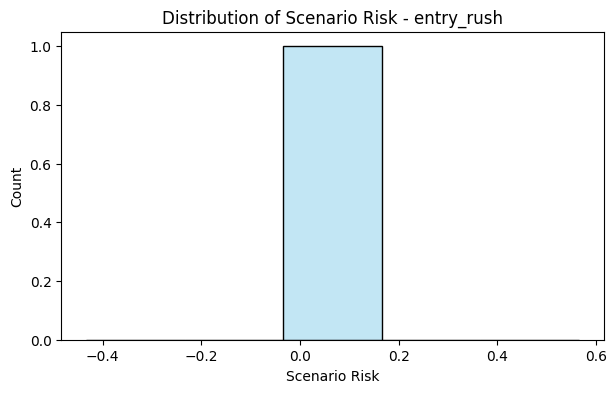

/tmp/ipykernel_4307/1339218665.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rec_counts.index, y=rec_counts.values, palette="viridis")


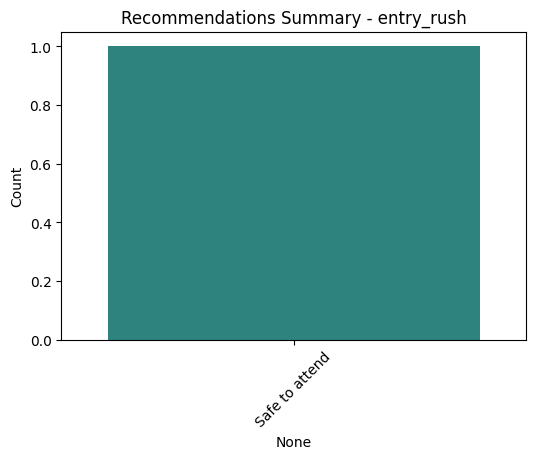

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Simple Risk Visualization
plt.figure(figsize=(8,5))
plt.plot(df_user.index+1, df_user["Base_Risk"], marker='o', label="Base Risk")
plt.plot(df_user.index+1, df_user["Scenario_Risk"], marker='s', label=f"Scenario Risk ({chosen_scenario})")
plt.xlabel("Row / Event")
plt.ylabel("Congestion Risk")
plt.title(f"Crowd Congestion Risk - Scenario: {chosen_scenario}")
plt.ylim(0,1.05)
plt.xticks(df_user.index+1)
plt.grid(True)
plt.legend()
plt.show()

# Risk Distribution (Histogram)
plt.figure(figsize=(7,4))
sns.histplot(df_user["Scenario_Risk"], bins=5, kde=True, color="skyblue")
plt.xlabel("Scenario Risk")
plt.title(f"Distribution of Scenario Risk - {chosen_scenario}")
plt.show()

# Recommendations Summary
rec_counts = df_user["Recommendation"].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=rec_counts.index, y=rec_counts.values, palette="viridis")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.title(f"Recommendations Summary - {chosen_scenario}")
plt.show()


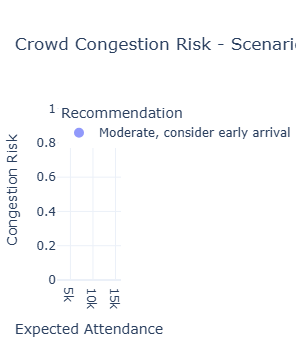

In [9]:
import plotly.express as px
import pandas as pd

# Example DataFrame
# df_user should have columns: Event_Type, Stadium, Expected_Attendance, Scenario_Risk, Recommendation
# For demonstration, let's create a mock df_user
df_user = pd.DataFrame({
    "Event_Type": ["Concert", "Football", "Basketball"],
    "Stadium": ["Stadium A", "Stadium B", "Stadium C"],
    "Expected_Attendance": [5000, 12000, 8000],
    "Scenario_Risk": [0.96, 1.0, 0.96],
    "Recommendation": ["Moderate, consider early arrival", 
                       "Moderate, consider early arrival", 
                       "Moderate, consider early arrival"]
})

chosen_scenario = "entry_rush"  # example

# Add scenario column
df_user["Scenario"] = chosen_scenario

fig = px.scatter(
    df_user,
    x="Expected_Attendance",
    y="Scenario_Risk",
    color="Recommendation",
    hover_data=["Event_Type", "Stadium", "Scenario_Risk", "Recommendation"],
    title=f"Crowd Congestion Risk - Scenario: {chosen_scenario}",
    size="Expected_Attendance",  # optional: size by attendance
    template="plotly_white"
)

fig.update_yaxes(range=[0,1.05], title="Congestion Risk")
fig.update_xaxes(title="Expected Attendance")

fig.show()


In [26]:
import boto3
import pandas as pd
from io import StringIO
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import json

def predict_from_s3_json(input_bucket, input_key, scenario, endpoint_name, 
                         output_bucket="crowd-predictions-demo-2025", s3_folder="predictions"):
    """
    Args:
        input_bucket (str): S3 bucket where input JSON is stored
        input_key (str): S3 key/path of the JSON file
        scenario (str): Scenario name ['general','entry_rush','mid_event','evacuation']
        endpoint_name (str): SageMaker endpoint name
        output_bucket (str): S3 bucket to save outputs
        s3_folder (str): Folder inside output bucket
    Returns:
        pd.DataFrame: Predictions + recommendations
        dict: Mappings for categorical columns
    """
    
    s3 = boto3.client("s3")
    
    response = s3.get_object(Bucket=input_bucket, Key=input_key)
    json_content = response['Body'].read().decode('utf-8')
    pdf_json = json.loads(json_content)

    rows = []
    for page in pdf_json.get("pages", []):
        row = {}
        for k, v in page.items():
            # Extract numeric if possible
            if isinstance(v, str) and ":" in v:
                try:
                    num = float(v.split(":")[1].strip())
                    row[k] = num
                except:
                    row[k] = 0
            elif isinstance(v, (int,float)):
                row[k] = v
            else:
                row[k] = v  # keep string
        row["Day_Hour"] = row.get("Day_Hour", 18)
        weather = page.get("Weather Severity","")
        if "Mild" in weather:
            row["Weather_Score"] = 0.5
        elif "Severe" in weather:
            row["Weather_Score"] = 1.0
        else:
            row["Weather_Score"] = 0.7
        rows.append(row)
    
    df = pd.DataFrame(rows)
    
    mappings = {}
    for col in df.columns:
        if df[col].dtype == object:
            unique_vals = sorted(df[col].dropna().unique())
            mapping = {val:i for i,val in enumerate(unique_vals)}
            df[col] = df[col].map(mapping)
            mappings[col] = mapping
    
    df_model_ready = df.copy()
    
    predictor = Predictor(endpoint_name=endpoint_name)
    predictor.serializer = CSVSerializer()
    predictions = predictor.predict(df_model_ready.values)
    if isinstance(predictions, bytes):
        predictions = predictions.decode("utf-8")
    
    risk_values = [float(x) for x in predictions.strip().split("\n")]
    df_model_ready["Congestion_Risk"] = risk_values

    def get_recommendation(risk, scenario):
        if scenario=="general":
            return "Safe to attend" if risk < 0.5 else "Moderate, consider early arrival"
        elif scenario=="entry_rush":
            return "Open extra gates"
        elif scenario=="mid_event":
            return "Redirect crowd to food/restroom areas"
        elif scenario=="evacuation":
            return "Activate emergency exits and guides"
        else:
            return "No recommendation"
    
    df_model_ready["Scenario"] = scenario
    df_model_ready["Recommendation"] = df_model_ready["Congestion_Risk"].apply(
        lambda r: get_recommendation(r, scenario)
    )

    csv_buffer = StringIO()
    df_model_ready.to_csv(csv_buffer, index=False)
    csv_key = f"{s3_folder}/prediction_{scenario}.csv"
    s3.put_object(Bucket=output_bucket, Key=csv_key, Body=csv_buffer.getvalue())
    
    plt.figure(figsize=(8,5))
    plt.bar(range(len(risk_values)), risk_values, color='skyblue')
    plt.xticks(range(len(risk_values)), [f"Row {i+1}" for i in range(len(risk_values))], rotation=45)
    plt.ylabel("Congestion Risk")
    plt.title(f"Scenario: {scenario}")
    plt.tight_layout()
    plt.savefig("/tmp/risk_plot.png")
    plt.close()
    s3.upload_file("/tmp/risk_plot.png", output_bucket, f"{s3_folder}/risk_plot_{scenario}.png")

    df_plot = df_model_ready.copy()
    df_plot["Expected_Attendance"] = df_plot.get("Capacity", df_plot.get("Expected_Attendance", [0]*len(df_plot)))
    fig = px.scatter(
        df_plot,
        x="Expected_Attendance",
        y="Congestion_Risk",
        color="Recommendation",
        hover_data=list(df_plot.columns),
        title=f"Crowd Congestion Risk - Scenario: {scenario}",
        size="Expected_Attendance",
        template="plotly_white"
    )
    html_file = f"/tmp/risk_plot_{scenario}.html"
    pio.write_html(fig, file=html_file, auto_open=False)
    s3.upload_file(html_file, output_bucket, f"{s3_folder}/risk_plot_{scenario}.html")
    
    print(f"✅ CSV saved: s3://{output_bucket}/{csv_key}")
    print(f"✅ Matplotlib plot saved: s3://{output_bucket}/{s3_folder}/risk_plot_{scenario}.png")
    print(f"✅ Interactive Plotly saved: s3://{output_bucket}/{s3_folder}/risk_plot_{scenario}.html")
    
    return df_model_ready, mappings
